In [13]:
import tensorflow as tf

# Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
x_train.shape

(50000, 32, 32, 3)

In [16]:
import numpy as np
import cv2

# Get Input image for VGG16
x_train_vgg = np.array([cv2.resize(img, (80, 80)) for img in x_train])
x_test_vgg = np.array([cv2.resize(img, (80, 80)) for img in x_test])

In [17]:
x_train_vgg.shape

(50000, 80, 80, 3)

In [18]:
x_train.shape

(50000, 32, 32, 3)

In [19]:
# Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_vgg, x_test_vgg = x_train_vgg / 255.0, x_test_vgg / 255.0

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=100)

In [27]:
num_classes = 100
input_shape = (32, 32, 3)

# Define Hyperparameter
# ViT Base
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
final_dropout_layer = 0.5
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    3072,
]

config_json = {   
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "image_size" : image_size,
    "patch_size" : patch_size,
    "num_patches" : num_patches,
    "projection_dim" : projection_dim,
    "num_heads" : num_heads,
    "final_dropout_layer" : final_dropout_layer,
    "transformer_units" : transformer_units,
    "transformer_layers" : transformer_layers,
    "mlp_head_units" : mlp_head_units
}

In [28]:
from modules.vision_transformers.patches import Patches
from modules.vision_transformers.patch_encoder import PatchEncoder, mlp

# Data Augmentation for resize
data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    #tf.keras.layers.RandomContrast(factor=0.1)
])

# Compute the average and variance of the training data for normalization purpose
#data_augmentation.layers[0].adapt(x_train)

In [29]:
vgg_conv = tf.keras.applications.VGG16(
        include_top=False,
        #input_shape=(64, 64, 3),
        weights='imagenet',
        classifier_activation=None
    )

# Define the model
def create_classifier():
    # Inputs for CNN
    inputs_cnn = tf.keras.layers.Input(shape=(80, 80, 3))

    output_vgg16 = vgg_conv(inputs_cnn)
    outputs_cnn = tf.keras.layers.Flatten()(output_vgg16)
    
    # Input for Transformer
    inputs_transformers = tf.keras.Input(shape=input_shape)
    
    # Apply augment resize
    augmented = data_augmentation(inputs_transformers)
    
    # Create Patches
    patches = Patches(patch_size)(augmented)

    # Encode every patches position
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        # Create multilayers about how many transformers layer needed
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # NLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip Connection
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation_transformers = tf.keras.layers.Dropout(final_dropout_layer)(representation)

    # Concat
    concatenated = tf.keras.layers.Concatenate()([outputs_cnn, representation_transformers])
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=final_dropout_layer)
    
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(concatenated)
    # Create the Keras model.
    model = tf.keras.Model(inputs=[inputs_cnn, inputs_transformers], outputs=logits)
    
    return model

model = create_classifier()

In [30]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 72, 72, 3) │          0 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, 144, 108)  │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 144, 64)   │     16,192 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 144, 128)  │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 144, 64)   │      8,256 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 144, 64)   │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 144, 64)   │          0 │ dropout_40[0][0], │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat

 Total params: 18,447,204 (70.37 MB)

 Trainable params: 18,447,204 (70.37 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
total_steps = len(x_train) * num_epochs
decay_steps = total_steps * 0.4
# Cosine Learning Rate Decay
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=0.1,
    warmup_steps=15000
)

In [32]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(3, name='top-5-accuracy')
    ]
)

In [33]:
history = model.fit(
    x=[x_train_vgg, x_train],
    y=y_train_categorical,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([x_test_vgg, x_test], y_test_categorical)
)

2024-06-13 14:05:05.996610: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.
2024-06-13 14:05:08.241746: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.


Epoch 1/10


2024-06-13 14:05:42.873270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-06-13 14:05:48.222223: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 74.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 14:05:48.281284: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 306.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 14:05:58.692781: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.19MiB (rounded to 15925248)requested by op StatefulPartitionedCall/functional_5_1/multi_head_attention_13_1/tra

ResourceExhaustedError: Graph execution error:

Detected at node functional_5_1/multi_head_attention_13_1/transpose_2 defined at (most recent call last):
  File "/root/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_420580/1653884352.py", line 1, in <module>

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/attention/multi_head_attention.py", line 473, in call

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/attention/multi_head_attention.py", line 415, in _compute_attention

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 2305, in einsum

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 320, in einsum

  File "/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 254, in use_custom_ops

OOM when allocating tensor with shape[16,12,144,144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node functional_5_1/multi_head_attention_13_1/transpose_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_59901]

In [18]:
x_test_vgg.shape

(10000, 80, 80, 3)

In [19]:
evaluated = model.evaluate([x_test_vgg, x_test], y_test_categorical)
final_acc, final_loss, final_top_3_acc = evaluated[0], evaluated[1], evaluated[2]

2024-06-13 13:43:09.854943: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.
2024-06-13 13:43:16.176224: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 238s 148ms/step - accuracy: 0.7054 - loss: 0.8271 - top-5-accuracy: 0.9295


In [15]:
save_name = 'model/model_cifar100_vgg_val'

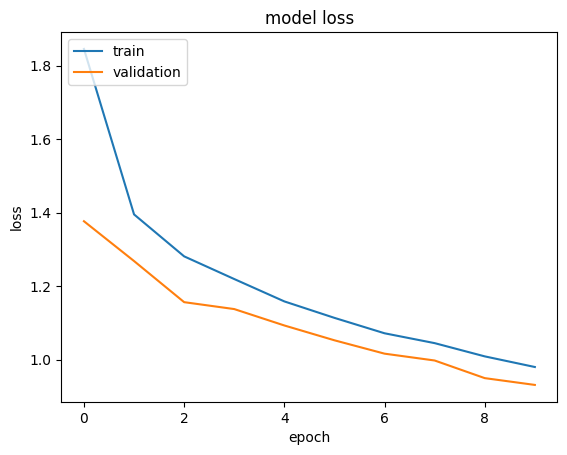

In [16]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
fig.savefig(save_name + "_loss.jpg")

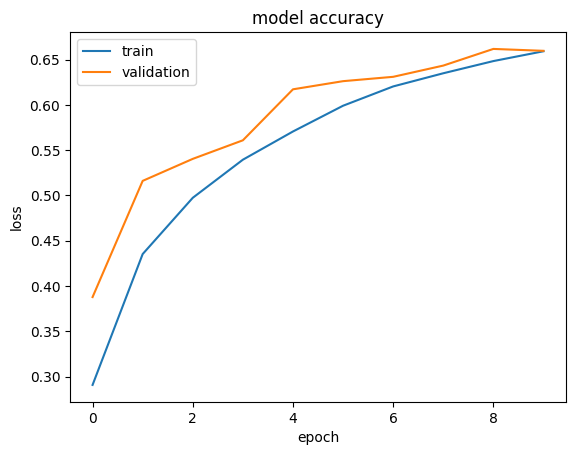

In [31]:
# Save Train result
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
fig.savefig(save_name + "_accuracy.jpg")

In [33]:
model.save('{}.keras'.format(save_name))

In [34]:
import json

config_json['final_accuracy'] = 0.6609
config_json['final_loss'] = 0.9449
config_json['final_top_3_acc'] = 0.9112
with open('{}_config.json'.format(save_name), 'w') as f:
    json.dump(config_json, f, indent=4)